# Cats vs Dogs CNN pretrained Data Augmentation

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# # se this piece of code to download kaggle data directly to colab
# upload kaggle json file on the colab
from google.colab import files
files.upload()
# make kaggle directory
!mkdir ~/.kaggle
# move kaggle file to newly created folder
!cp kaggle.json ~/.kaggle/
# chnage permissions for file created
!chmod 600 ~/.kaggle/kaggle.json
# Downlaod data from kaggle
!kaggle competitions download -c dogs-vs-cats

# unzip downloaded data
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

# Copying images to training, validation, and test directories
# imports
import os, shutil, pathlib
# path to complete data set 
original_dir = pathlib.Path("train")
# path to smaller data set
new_base_dir = pathlib.Path("cats_vs_dogs_small")
# function to get images from complete set and save in subset
def make_subset(subset_name, start_index, end_index):
  # loop over cat and dog category
  for category in ("cat", "dog"):
    # path to new directory
    dir = new_base_dir / subset_name / category
    # make new directories
    os.makedirs(dir)
    # range of files names
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      # copy files from source to target
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
# call sfor train, validation and test set
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

# Using image_dataset_from_directory to read images
  # image_dataset_from_directory(directory) will list the subdirectories of directory
  # index the image files in each subdirectory
  # create and return a tf.data.Dataset object 
    # configured to read these files, 
    # shuffle them
    # decode them to tensors
    # resize them to a shared size
    # and pack them into batches.

from tensorflow.keras.utils import image_dataset_from_directory
 
# create datasets
train_dataset = image_dataset_from_directory(
    # path of the directory
    new_base_dir / "train",
    # reshape images to said size
    image_size=(180, 180),
    # batch size / 32 samples per batch
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

# Displaying the shapes of the data and labels yielded by the Dataset
for i, element in enumerate(train_dataset):
  pass
print("bathces of train_dataset : ",i)
for train_data_batch, train_labels_batch in train_dataset:
  print("train data batch shape:", train_data_batch.shape)
  print("train labels batch shape:", train_labels_batch.shape)
  break
for i, element in enumerate(validation_dataset):
  pass
print("bathces of validation_dataset : ",i)
for validation_data_batch, validation_labels_batch in validation_dataset:
  print("validation data batch shape:", validation_data_batch.shape)
  print("validation labels batch shape:", validation_labels_batch.shape)
  break
for i, element in enumerate(test_dataset):
  pass
print("bathces of test_dataset : ",i)
for test_data_batch, test_labels_batch in test_dataset:
  print("test data batch shape:", test_data_batch.shape)
  print("test labels batch shape:", test_labels_batch.shape)
  break

Mounted at /content/drive


Saving kaggle.json to kaggle.json
 99% 806M/812M [00:03<00:00, 211MB/s]
100% 812M/812M [00:03<00:00, 246MB/s]
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
bathces of train_dataset :  62
train data batch shape: (32, 180, 180, 3)
train labels batch shape: (32,)
bathces of validation_dataset :  31
validation data batch shape: (32, 180, 180, 3)
validation labels batch shape: (32,)
bathces of test_dataset :  62
test data batch shape: (32, 180, 180, 3)
test labels batch shape: (32,)


In [8]:
# Listing 8.23 Instantiating and freezing the VGG16 convolutional base
from tensorflow import keras
from tensorflow.keras import layers
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [9]:
# Listing 8.24 Printing the list of trainable weights before and after freezing
conv_base.trainable = True
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


# create a new model that chains together
  1. A data augmentation stage
  2. Our frozen convolutional base
  3. A dense classifier

In [10]:
# Listing 8.25 Adding a data augmentation stage and a classifier to the convolutional base

data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ]
)
 
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="cats_vs_dogs_small_feature_extraction_with_data_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 29s 434ms/step - loss: 16.9210 - accuracy: 0.9005 - val_loss: 8.2322 - val_accuracy: 0.9560
Epoch 2/50
63/63 [==============================] - 27s 427ms/step - loss: 7.9746 - accuracy: 0.9410 - val_loss: 3.9438 - val_accuracy: 0.9740
Epoch 3/50
63/63 [==============================] - 27s 428ms/step - loss: 5.9098 - accuracy: 0.9570 - val_loss: 4.8023 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 27s 427ms/step - loss: 5.5120 - accuracy: 0.9595 - val_loss: 3.2127 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 27s 425ms/step - loss: 4.7016 - accuracy: 0.9635 - val_loss: 8.7847 - val_accuracy: 0.9590
Epoch 6/50
63/63 [==============================] - 27s 426ms/step - loss: 4.1559 - accuracy: 0.9670 - val_loss: 5.9852 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 27s 430ms/step - loss: 3.8907 - accuracy: 0.9690 - val_loss: 7.6060 - val_accuracy: 0.963

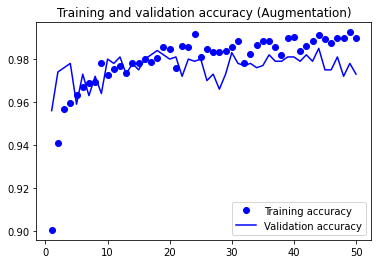

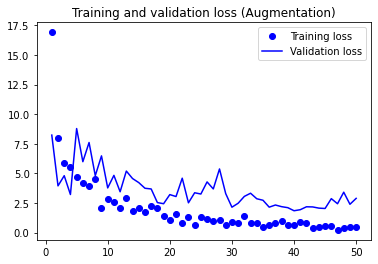

In [12]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy (Augmentation)")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss (Augmentation)")
plt.legend()
plt.show()

In [13]:
# Listing 8.26 Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 18s 270ms/step - loss: 2.6372 - accuracy: 0.9735
Test accuracy: 0.974
